In [1]:
# https://www.linkedin.com/posts/peter-atwood-60b9ba18a_30daymapchallenge-blender3d-gis-ugcPost-7128461310337380352-AjqQ?utm_source=share&utm_medium=member_desktop

# Perhaps with tides?

In [2]:
from __future__ import annotations

import numpy as np

import geovista as gv
from geovista.samples import regular_grid
import geovista.theme

import pyvista as pv

import xarray as xr

from holoviews import opts

import pvxarray

import os.path

import cdsapi

In [3]:
# Get wind and solar data for a week
year = 2024
month = 5
day = 10

for day in range(10,13,1):
    outfile = f"data/era5_{year}{month:02}{day:02}.nc"

    if not os.path.isfile(outfile):
        
        c = cdsapi.Client()

        cds_dataset = "reanalysis-era5-single-levels"
        cds_request = {
            "product_type": "reanalysis",
            "format": "netcdf",
            "variable": [
                "100m_u_component_of_wind", "100m_v_component_of_wind", "surface_solar_radiation_downwards",
            ],
            "year": year,
            "month": month,
            "day":day,
            'time': [
                    '00:00', '01:00', '02:00',
                    '03:00', '04:00', '05:00',
                    '06:00', '07:00', '08:00',
                    '09:00', '10:00', '11:00',
                    '12:00', '13:00', '14:00',
                    '15:00', '16:00', '17:00',
                    '18:00', '19:00', '20:00',
                    '21:00', '22:00', '23:00',
                ],
        }

        cds_request.update({"year":str(year), "month":str(month), "day":str(day)})

        print(cds_request)

        c.retrieve(cds_dataset, cds_request, outfile)


In [4]:
xr_aurora = xr.open_dataset(r"C:\Users\Charlie\Documents\GitHub\OvationPyme\data\aurora_intensity_202405100000.nc")

c:\Users\Charlie\Documents\GitHub\mapping-challenge\.venv\Lib\site-packages\xarray\backends\plugins.py:110: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


In [5]:
xr_aurora

<xarray.Dataset> Size: 184kB
Dimensions:    (y: 80, x: 96, time: 1)
Coordinates:
    lat        (y, x) float64 61kB ...
    lon        (y, x) float64 61kB ...
  * time       (time) datetime64[ns] 8B 2024-05-10
Dimensions without coordinates: y, x
Data variables:
    intensity  (time, y, x) float64 61kB ...

In [6]:
xr_aurora = xr.open_mfdataset(r"C:\Users\Charlie\Documents\GitHub\OvationPyme\data\aurora_intensity_2024*00.nc")

In [7]:
# Extract unique latitude and longitude values
lat_1d = xr_aurora.lat[:, 0].values  # Take the first column for unique latitudes
lon_1d = xr_aurora.lon[0, :].values  # Take the first row for unique longitudes

# Assign the new 1D coordinates to the dataset
xr_aurora = xr_aurora.assign_coords(
    latitude=("y", lat_1d),  # Replace lat with 1D values
    longitude=("x", lon_1d)   # Replace lon with 1D values
)

In [8]:
xr_aurora

<xarray.Dataset> Size: 5MB
Dimensions:    (time: 72, y: 80, x: 96)
Coordinates:
    lat        (y, x) float64 61kB dask.array<chunksize=(80, 96), meta=np.ndarray>
    lon        (y, x) float64 61kB dask.array<chunksize=(80, 96), meta=np.ndarray>
  * time       (time) datetime64[ns] 576B 2024-05-10 ... 2024-05-12T23:00:00
    latitude   (y) float64 640B 50.0 50.51 51.01 51.52 ... 88.99 89.49 90.0
    longitude  (x) float64 768B 0.0 3.789 7.579 11.37 ... 352.4 356.2 360.0
Dimensions without coordinates: y, x
Data variables:
    intensity  (time, y, x) float64 4MB dask.array<chunksize=(1, 80, 96), meta=np.ndarray>

In [9]:
xr_aurora_coarse = xr_aurora.isel(time=1)

x_aur = xr_aurora_coarse["longitude"].values
y_aur = xr_aurora_coarse["latitude"].values

z_aur = xr_aurora_coarse["intensity"].values
z_aur = z_aur/z_aur.max()

x_aur = np.hstack([x_aur,x_aur[0]])
z_aur = np.vstack([z_aur.T,z_aur[:,0]]).T

mesh_aurora = gv.Transform.from_1d(x_aur, y_aur, data=z_aur)

In [10]:
mesh_aurora

PolyData (0x28dc6507dc0)
  N Cells:    7584
  N Points:   7760
  N Strips:   0
  X Bounds:   -6.424e-01, 6.428e-01
  Y Bounds:   -6.427e-01, 6.427e-01
  Z Bounds:   7.660e-01, 1.000e+00
  N Arrays:   4

In [11]:
xr_era5 = xr.open_mfdataset("data/era5*.nc")

In [12]:
xr_era5

<xarray.Dataset> Size: 897MB
Dimensions:     (valid_time: 72, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 576B 2024-05-10 ... 2024-05-12T23...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 1kB dask.array<chunksize=(24,), meta=np.ndarray>
Data variables:
    u100        (valid_time, latitude, longitude) float32 299MB dask.array<chunksize=(12, 361, 720), meta=np.ndarray>
    v100        (valid_time, latitude, longitude) float32 299MB dask.array<chunksize=(12, 361, 720), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 299MB dask.array<chunksize=(12, 361, 720), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-16T12:20 GRIB to CDM+CF via cfgrib-0.9.1...

In [13]:
step = 5

xr_era5_coarse_time = xr_era5.isel(longitude=np.arange(0,len(xr_era5.longitude),step=step),latitude=np.arange(0,len(xr_era5.latitude),step=step))

In [14]:
xr_era5_coarse = xr_era5_coarse_time.isel(valid_time=8)

In [15]:
xr_era5_coarse

<xarray.Dataset> Size: 505kB
Dimensions:     (latitude: 145, longitude: 288)
Coordinates:
    number      int64 8B 0
    valid_time  datetime64[ns] 8B 2024-05-10T08:00:00
  * latitude    (latitude) float64 1kB 90.0 88.75 87.5 ... -87.5 -88.75 -90.0
  * longitude   (longitude) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
    expver      <U4 16B dask.array<chunksize=(), meta=np.ndarray>
Data variables:
    u100        (latitude, longitude) float32 167kB dask.array<chunksize=(73, 144), meta=np.ndarray>
    v100        (latitude, longitude) float32 167kB dask.array<chunksize=(73, 144), meta=np.ndarray>
    ssrd        (latitude, longitude) float32 167kB dask.array<chunksize=(73, 144), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-16T12:20 GRIB to CDM+CF via cfgrib-0.9.1...

In [16]:
# xr_era5_coarse = xr_era5_coarse_time.isel(time=8)

x_sol = xr_era5_coarse["longitude"].values
y_sol = xr_era5_coarse["latitude"].values

z_sol = xr_era5_coarse["ssrd"].values
z_sol = z_sol/z_sol.max()

x_sol = np.hstack([x_sol,x_sol[0]])
# y_sol = np.hstack([y_sol,y_sol[0]])
z_sol = np.vstack([z_sol.T,z_sol[:,0]]).T

#mesh_solar = gv.Transform.from_1d(x_sol, y_sol, data=z_sol)
mesh_solar = gv.Transform.from_1d(x_sol, y_sol, data=z_sol)


In [17]:
print(x_sol.shape)
print(y_sol.shape)
print(z_sol.shape)

(289,)
(145,)
(145, 289)


In [18]:
class SetVisibilityCallback:
    """Helper callback to keep a reference to the actor being modified."""

    def __init__(self, actor):
        self.actor = actor

    def __call__(self, state):
        self.actor.SetVisibility(state)

In [19]:
x_wnd = xr_era5_coarse["longitude"].values
y_wnd = xr_era5_coarse["latitude"].values

u_wnd = xr_era5_coarse["u100"].values.flatten()
v_wnd = xr_era5_coarse["v100"].values.flatten()

mesh_wnd = gv.Transform.from_1d(x_wnd, y_wnd)
mesh_wnd["vectors"] = np.vstack([u_wnd,v_wnd]).T

In [20]:
# Generate a meshgrid.
lon,lat = np.meshgrid(xr_era5_coarse["longitude"],xr_era5_coarse["latitude"])

# convert to 3D sphere
lon = lon.flatten()*np.pi/180
lat = lat.flatten()*np.pi/180
radius = 1.1

x = np.sin(np.pi/2-lat) * np.cos(lon)
y = np.sin(np.pi/2-lat) * np.sin(lon)
z = np.cos(np.pi/2-lat)

mesh_array = radius*np.vstack([x,y,z]).T

mesh = pv.PolyData(mesh_array)

u100 = xr_era5_coarse["u100"].values.flatten()
v100 = xr_era5_coarse["v100"].values.flatten()

x100 = u100*np.sin(lon)+v100*np.sin(lat)*np.cos(lon)
y100 = -u100*np.sin(lon+np.pi/2)+v100*np.sin(lat)*np.sin(lon)
z100 = -v100*np.cos(lat)

scale_vector = 0.002

mesh["vectors"] = np.vstack((x100,y100,z100)).T * scale_vector
mesh.set_active_vectors("vectors")


In [21]:
mesh_wnd["vectors"] = np.vstack((x100,y100,z100)).T * scale_vector
mesh_wnd.set_active_vectors("vectors")

# Plot the vectors.
plotter = gv.GeoPlotter()
plotter.add_base_layer(texture=gv.natural_earth_1(), radius=.999, lighting=False)
#plotter.add_mesh(mesh.arrows, lighting=False)

actor = plotter.add_mesh(mesh_aurora, radius=0.9999, scalars="point_data", cmap="plasma", opacity="linear", lighting=False, label='Aurora')
callback = SetVisibilityCallback(actor)
plotter.add_checkbox_button_widget(
            callback,
            value=True,
            position=(1000, 570),
            size=30,
            border_size=1,
            color_on="red",
            color_off='grey',
            background_color='grey',
        )

actor = plotter.add_mesh(mesh_solar, radius=0.9999, cmap="cividis", opacity="linear_r", lighting=False, label='Sun')
callback = SetVisibilityCallback(actor)
plotter.add_checkbox_button_widget(
            callback,
            value=True,
            position=(1000, 540),
            size=30,
            border_size=1,
            color_on="yellow",
            color_off='grey',
            background_color='grey',
        )

plotter.add_coastlines(color="white", radius=0.99999)

actor = plotter.add_mesh(mesh_wnd.arrows, radius=0.999999, lighting=False, label='Wind')
callback = SetVisibilityCallback(actor)
plotter.add_checkbox_button_widget(
            callback,
            value=True,
            position=(1000, 510),
            size=30,
            border_size=1,
            color_on="green",
            color_off='grey',
            background_color='grey',
        )

plotter.add_legend(bcolor=None, face=None, size=(0.1,0.1), loc="upper right")

plotter.add_axes()
plotter.camera.zoom(1)
plotter.show()

c:\Users\Charlie\Documents\GitHub\mapping-challenge\.venv\Lib\site-packages\pyvista\core\pointset.py:1129: PyVistaDeprecationWarning: The current behavior of `pv.PolyData.n_faces` has been deprecated.
                Use `pv.PolyData.n_cells` or `pv.PolyData.n_faces_strict` instead.
                See the documentation in '`pv.PolyData.n_faces` for more information.
  warnings.warn(
c:\Users\Charlie\Documents\GitHub\mapping-challenge\.venv\Lib\site-packages\pyvista\core\dataset.py:595: PyVistaDeprecationWarning: Use of `DataSet.active_t_coords` is deprecated. Use `DataSet.active_texture_coordinates` instead.
  warnings.warn(


Widget(value='<iframe src="http://localhost:53509/index.html?ui=P_0x28dc7c23e50_0&reconnect=auto" class="pyvis…

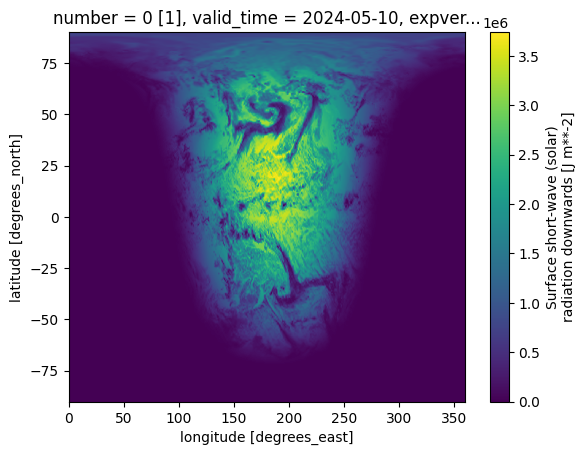

In [22]:
xr_era5.ssrd[0].plot(x="longitude", y="latitude")

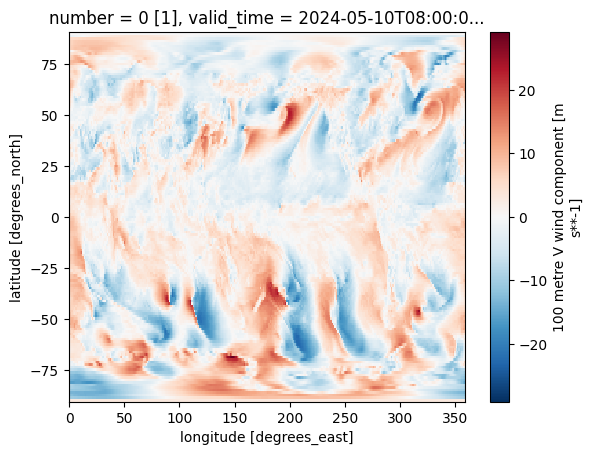

In [23]:
xr_era5_coarse["v100"].plot()

In [32]:
for colormap in ["hsv"]: #["prism","hsv","turbo","viridis","brg"]:
    print(colormap)

    plotter = gv.GeoPlotter(off_screen=True, window_size=[512,512])#,image_scale=0.5)

    # optimize for size
    plotter.open_gif(f"Map2411-Arctic-{colormap}.gif", palettesize=16, subrectangles=True)

    # initiate image and static values
    plotter.add_base_layer(texture=gv.natural_earth_1(), radius=.999, lighting=False)
    plotter.add_coastlines(color="white", radius=0.99999)

    plotter.camera.zoom(1)

    # Adjust the camera to look from above
    plotter.camera_position = [
        (0, 0, 4),  # Camera position (above the scene)
        (0, 0, 0),    # Focal point (center of the scene)
        (0, 1, 0),    # View up vector (aligned with Y-axis)
    ]


    xr_aurora_coarse = xr_aurora.isel(time=1)
    x_aur = xr_aurora_coarse["longitude"].values
    y_aur = xr_aurora_coarse["latitude"].values
    z_aur = xr_aurora_coarse["intensity"].values
    z_aur = z_aur/z_aur.max()
    x_aur = np.hstack([x_aur,x_aur[0]])
    z_aur = np.vstack([z_aur.T,z_aur[:,0]]).T


    xr_era5_coarse = xr_era5_coarse_time.isel(valid_time=1)
    x_sol = xr_era5_coarse["longitude"].values
    y_sol = xr_era5_coarse["latitude"].values
    z_sol = xr_era5_coarse["ssrd"].values
    z_sol = z_sol/z_sol.max()

    x_sol = np.hstack([x_sol,x_sol[0]])
    z_sol = np.vstack([z_sol.T,z_sol[:,0]]).T


    # clear and overwrite the mesh on each frame
    n_frames = 72
    for time_step in range(n_frames):
        print(time_step)

        # mesh aurora
        xr_aurora_coarse = xr_aurora.isel(time=time_step)   
        z_aur = xr_aurora_coarse["intensity"].values
        z_aur = z_aur/z_aur.max()
        z_aur = np.vstack([z_aur.T,z_aur[:,0]]).T
        mesh_aurora = gv.Transform.from_1d(x_aur, y_aur, data=z_aur)
        mesh_aurora = mesh_aurora.rotate_z(-(time_step+3)*360/24)

        # mesh ERA5
        xr_era5_coarse = xr_era5_coarse_time.isel(valid_time=time_step)

        # mesh solar
        z_sol = xr_era5_coarse["ssrd"].values
        z_sol = z_sol/z_sol.max()
        z_sol = np.vstack([z_sol.T,z_sol[:,0]]).T

        mesh_solar = gv.Transform.from_1d(x_sol, y_sol, data=z_sol)


        # # mesh wind with arrows
        # mesh_wnd = gv.Transform.from_1d(x_wnd, y_wnd)

        # # Generate a meshgrid.
        # lon,lat = np.meshgrid(xr_era5_coarse["longitude"],xr_era5_coarse["latitude"])

        # # convert to 3D sphere
        # lon = lon.flatten()*np.pi/180
        # lat = lat.flatten()*np.pi/180

        # u100 = xr_era5_coarse["u100"].values.flatten()
        # v100 = xr_era5_coarse["v100"].values.flatten()

        # x100 = u100*np.sin(lon)+v100*np.sin(lat)*np.cos(lon)
        # y100 = -u100*np.sin(lon+np.pi/2)+v100*np.sin(lat)*np.sin(lon)
        # z100 = -v100*np.cos(lat)

        # mesh_wnd["vectors"] = np.vstack((x100,y100,z100)).T * scale_vector
        # mesh_wnd.set_active_vectors("vectors")

        # Plot the vectors
        actor_aurora = plotter.add_mesh(mesh_aurora, radius=0.9999, cmap=colormap, opacity="linear", lighting=False, label='Aurora', show_scalar_bar=False)
        
        actor_solar = plotter.add_mesh(mesh_solar, radius=0.9999, cmap="cividis", opacity="linear_r", lighting=False, label='Sun', show_scalar_bar=False)

        # actor_wind = plotter.add_mesh(mesh_wnd.arrows, radius=0.999999, lighting=False, label='Wind', show_scalar_bar=False)

        actor_text = plotter.add_text(
            str(xr_era5_coarse.valid_time.values)[:13],
            position="upper_left",
            font_size=10,
            shadow=True,
        )

        plotter.write_frame()  # Write this frame

        plotter.remove_actor(actor_aurora)
        plotter.remove_actor(actor_solar)
        # plotter.remove_actor(actor_wind)
        plotter.remove_actor(actor_text)




    # Be sure to close the plotter when finished
    plotter.close()


    # plotter.add_legend(bcolor=None, face=None, size=(0.1,0.1), loc="upper right")

    # plotter.add_axes()

    # plotter.show()

hsv
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


In [33]:
from pygifsicle import optimize
optimize("Map2411-Arctic-hsv.gif")